<h2>Titanic Survival Analysis</h2>
Author: Sean Cannon

#### Load Packages

In [24]:
# import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from IPython.display import display
import os

# sklearn
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics

# scaling
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# set random seed
RSEED = 2

%matplotlib inline

pd.set_option('display.max_rows', 100)

# to suppress warnings
#import warnings
#warnings.filterwarnings('ignore')

#### Read in the data

In [25]:
# load the titanic training dataset from csv
# train = pd.read_csv('train.csv', dtype={
#     'PassengerId': 'string',
#     'Survived': 'int64',
#     'Pclass': 'string',
#     'Name': 'string',
#     'Sex': 'string',
#     'Age': 'float64',
#     'SibSp': 'string',
#     'Parch': 'string',
#     'Ticket': 'string',
#     'Fare': 'float64',
#     'Cabin': 'string',
#     'Embarked': 'string',
# })

train = pd.read_csv('train.csv')

def shape(x):
    rows, cols = x.shape
    print(f"There are {rows} rows and {cols} columns in the dataset")

# observe the rows and columns
shape(train)

# view the dataset with head()
train.head()

There are 891 rows and 12 columns in the dataset


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


#### Summary Statistics

In [26]:
display(train.describe().T)
display(train.info())

,count,mean,std,min,25%,50%,75%,max
PassengerId,891.0,446.000000,257.353842,1.00,223.5000,446.0000,668.5,891.0000
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
Age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


None

#### Duplicate Values and Missings

In [27]:
train.duplicated().sum()

# drop the duplicates in the dataset
# df = df.drop_duplicates()

0

In [28]:
# check for missing values in the dataset
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

### Visualize

In [29]:
# Sort into lists based on datatypes
# float_col=[]
# object_col=[]
# int_col=[]
# for col in list(train.columns):
#     if train[col].dtype == 'int32':
#         int_col.append(col)
#     elif train[col].dtype == 'float64':
#         float_col.append(col)
#     else:
#         object_col.append(col)
        
# continuous = train[int_col + float_col]
# objects = train[object_col]

In [30]:
#creating histograms
# continuous.hist(figsize=(14,14))
# plt.show()

#### Tabulations

In [31]:
# sns.set_style("whitegrid")

# for col in objects.columns[4:]:                                                      
#     objects[col].value_counts().plot(kind='bar', rot = 0, alpha=0.8, color='#00429d')
#     ax = plt.subplot(111)
#     ax.set_title(col)
#     ax.spines[['top', 'right','left','bottom']].set_visible(True)
#     #ax.grid(False)
#     ax.grid(axis='x')
#     ax.set_facecolor("white")
#     plt.show()

#### Preprocess

In [32]:
# create a new title column from name
train['Title'] = train['Name'].str.extract('([A-Za-z]+)\.', expand=True)

# replace rare titles with more common ones
mapping = {'Mlle': 'Miss', 'Major': 'Mr', 'Col': 'Mr', 'Sir': 'Mr',
           'Don': 'Mr', 'Mme': 'Mrs', 'Jonkheer': 'Mr', 'Lady': 'Mrs',
           'Capt': 'Mr', 'Countess': 'Mrs', 'Ms': 'Miss', 'Dona': 'Mrs'}
train.replace({'Title': mapping}, inplace=True)

train['Title'].value_counts()

Title
Mr        525
Miss      185
Mrs       128
Master     40
Dr          7
Rev         6
Name: count, dtype: int64

In [33]:
# impute embarked
train['Embarked'].fillna(method='backfill', inplace=True)

train['Embarked'].isnull().sum()

/tmp/ipykernel_232345/3939582996.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['Embarked'].fillna(method='backfill', inplace=True)
/tmp/ipykernel_232345/3939582996.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train['Embarked'].fillna(method='backfill', inplace=True)


0

In [34]:
# find the median age

median_age = train['Age'].median()
median_age


28.0

In [35]:
# impute age using median
train['Age'] = train['Age'].fillna(train['Age'].median())

train['Age'].isnull().sum()

0

In [36]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     891 non-null    object 
 12  Title        891 non-null    object 
dtypes: float64(2), int64(5), object(6)
memory usage: 90.6+ KB


In [37]:
#split dataset in features and target variable
feature_cols = ['Pclass', 'Sex', 'Age', 'SibSp','Parch','Embarked','Title']
X = train[feature_cols] # Features
X = pd.get_dummies(X, drop_first=True)
y = train['Survived'] # Target variable

In [38]:
# Split dataset into training set and test set
test = pd.read_csv('test.csv')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test

In [39]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier(random_state=1)

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

In [40]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7649253731343284


In [41]:
text_representation = tree.export_text(clf)
print(text_representation)

|--- feature_9 <= 0.50
|   |--- feature_0 <= 2.50
|   |   |--- feature_11 <= 0.50
|   |   |   |--- feature_0 <= 1.50
|   |   |   |   |--- feature_1 <= 3.00
|   |   |   |   |   |--- feature_4 <= 0.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- feature_4 >  0.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |--- feature_1 >  3.00
|   |   |   |   |   |--- feature_1 <= 49.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- feature_1 >  49.50
|   |   |   |   |   |   |--- feature_1 <= 51.00
|   |   |   |   |   |   |   |--- feature_8 <= 0.50
|   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |--- feature_8 >  0.50
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- feature_1 >  51.00
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |--- feature_0 >  1.50
|   |   |   |   |--- feature_1 <= 22.50
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- feature_1 >  22.50
|   |   |   |   |   |--- feature_4 <

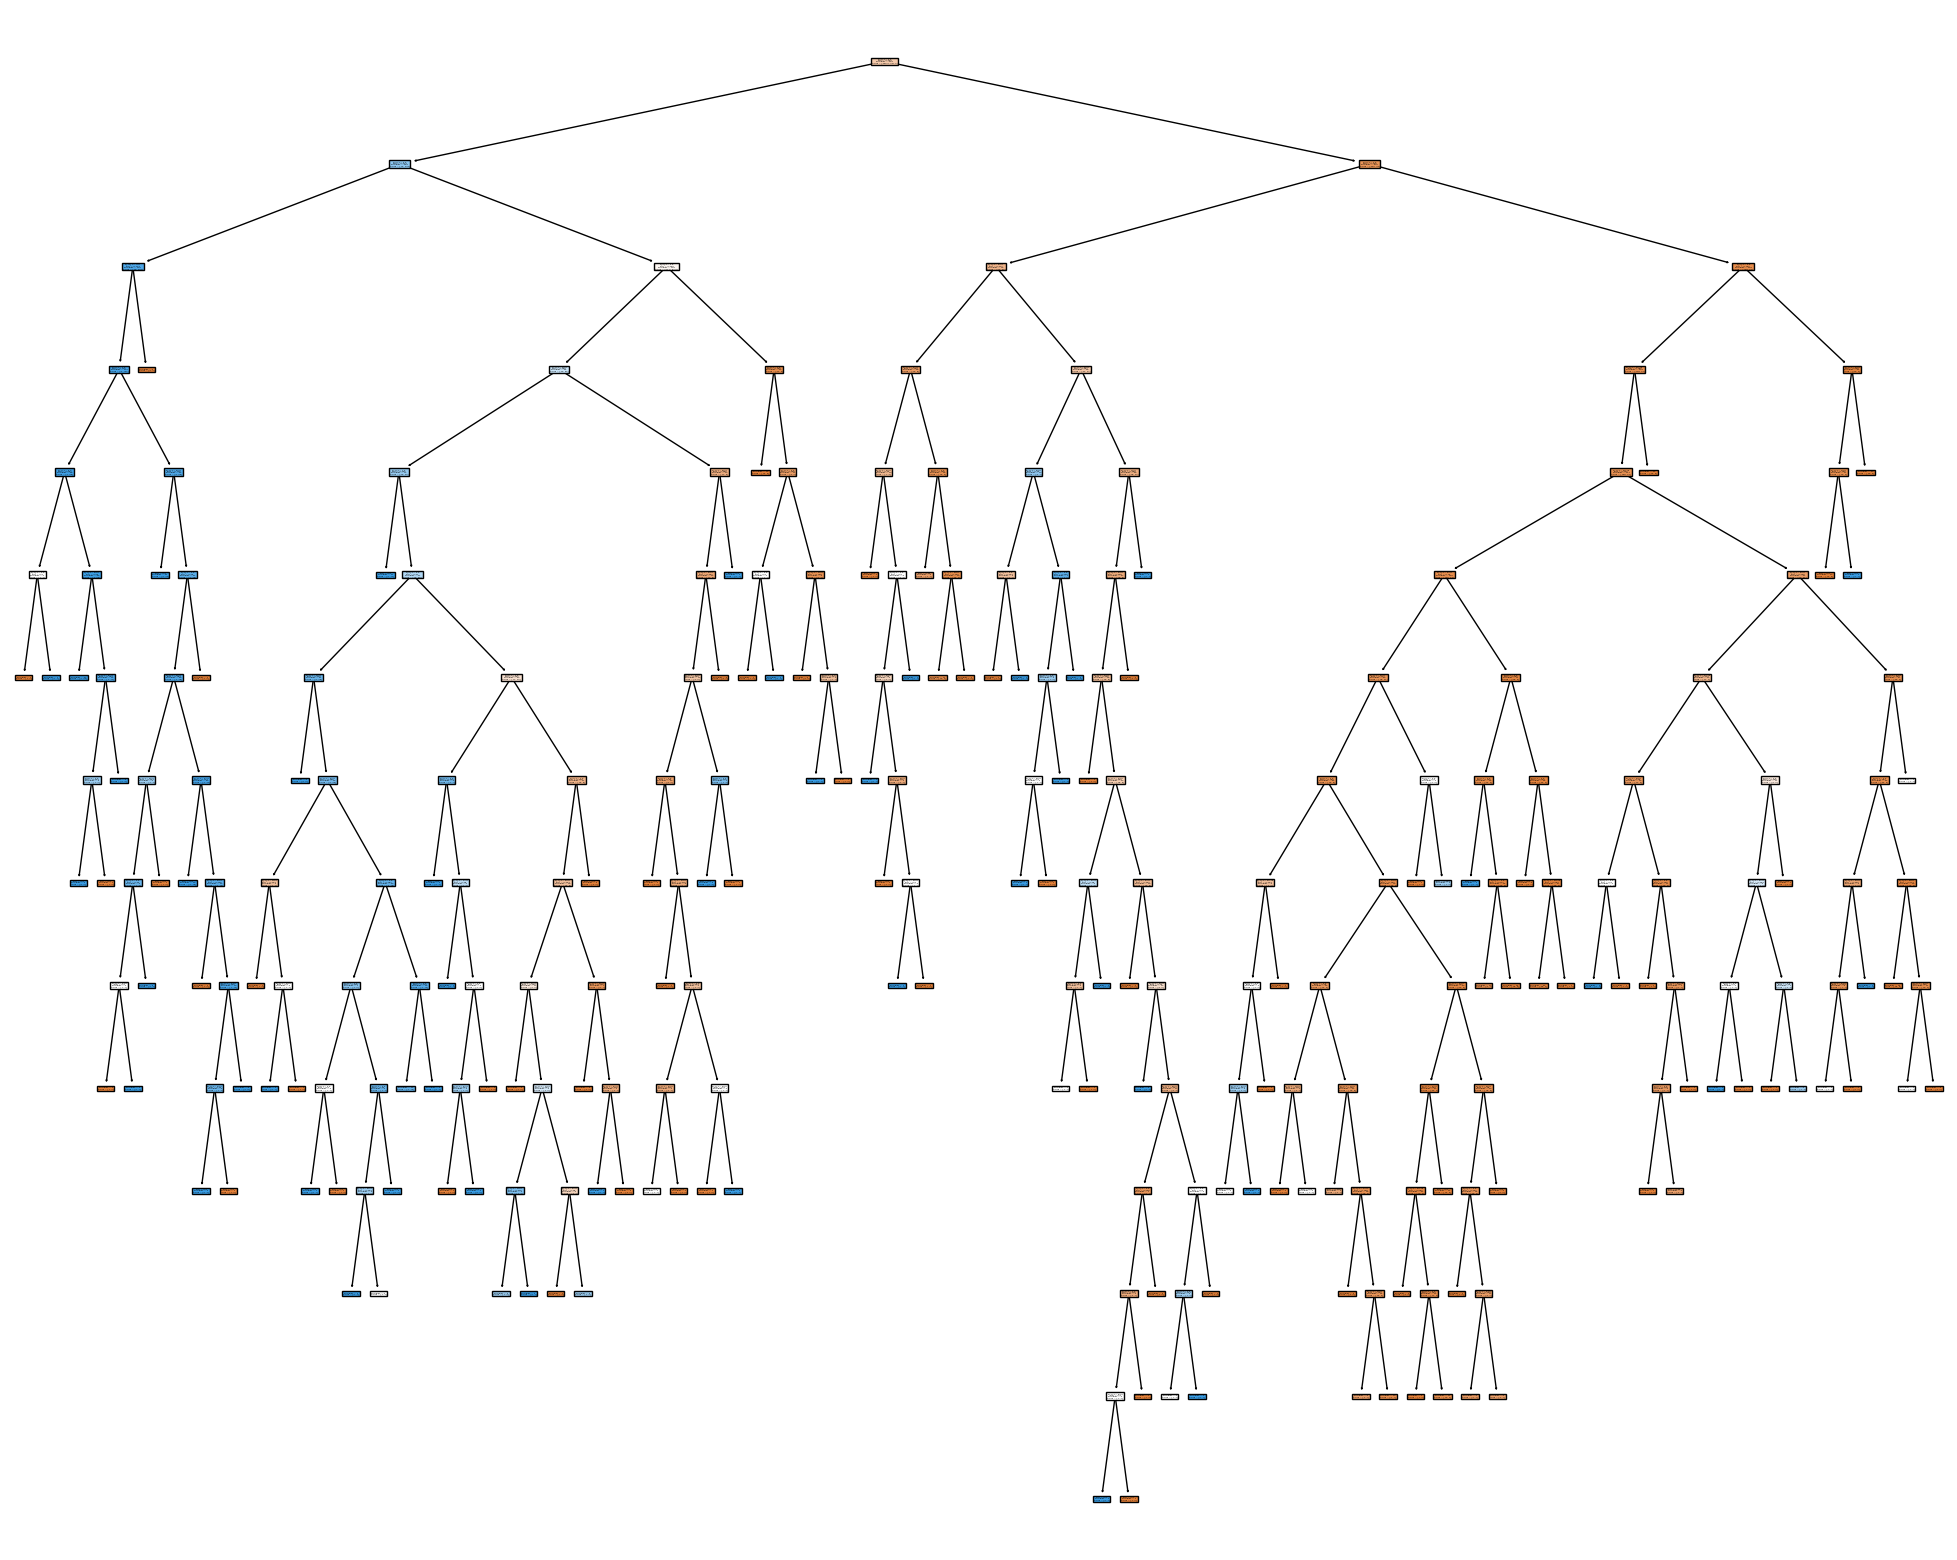

In [42]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(clf,
                   filled=True)

In [43]:
#display(test.info())

# process the test dataset

# create a new title column from name
test['Title'] = test['Name'].str.extract('([A-Za-z]+)\.', expand=True)

# replace rare titles with more common ones
mapping = {'Mlle': 'Miss', 'Major': 'Mr', 'Col': 'Mr', 'Sir': 'Mr',
           'Don': 'Mr', 'Mme': 'Mrs', 'Jonkheer': 'Mr', 'Lady': 'Mrs',
           'Capt': 'Mr', 'Countess': 'Mrs', 'Ms': 'Miss', 'Dona': 'Mrs'}

test.replace({'Title': mapping}, inplace=True)

# impute embarked
test['Embarked'].fillna(method='backfill', inplace=True)

# impute age using median
test['Age'] = test['Age'].fillna(test['Age'].median())

test_post = test[feature_cols] # Features
test_post = pd.get_dummies(test_post, drop_first=True)

#Predict the response for test dataset
predictions = clf.predict(test_post)

print(predictions)

[0 0 0 1 0 0 0 0 0 0 1 0 1 0 1 1 0 0 1 0 0 1 1 0 1 0 1 1 0 0 0 0 1 0 0 0 1
 0 0 1 0 1 0 1 1 0 0 1 1 1 1 0 1 1 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 1 1 0 0 0
 1 0 1 1 0 1 1 0 1 1 0 0 1 1 1 1 0 1 1 1 0 0 1 0 0 0 1 0 1 0 1 0 0 1 1 0 1
 1 1 1 1 0 1 1 0 1 1 0 1 0 1 1 0 1 1 0 1 1 1 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0
 1 0 1 1 0 1 0 0 1 0 1 1 1 1 0 1 0 0 1 0 1 1 1 1 0 1 0 1 1 0 1 1 0 0 1 1 1
 0 1 0 0 0 0 1 1 0 1 0 1 1 0 1 1 1 0 1 0 0 0 0 1 0 1 1 0 1 1 1 1 0 1 1 1 0
 1 0 1 0 0 1 0 0 0 1 0 1 0 0 0 0 1 1 1 1 0 1 0 0 1 0 1 1 1 0 0 0 1 1 1 0 1
 0 0 0 1 1 0 1 1 1 1 0 0 1 1 1 1 1 0 0 0 0 0 1 1 1 1 0 1 1 1 1 1 0 1 1 0 0
 1 0 0 0 1 0 1 0 1 1 0 1 0 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 1 0 1 0 0 0 1 0 1
 1 1 0 0 0 0 1 0 1 0 1 0 0 0 1 0 1 1 0 0 0 1 1 1 1 1 0 0 1 1 1 1 0 0 1 1 1
 0 1 1 1 1 1 0 0 0 0 1 0 1 0 0 1 0 0 0 0 1 1 1 0 0 1 0 1 0 0 1 0 1 0 1 0 0
 0 1 1 1 1 0 1 1 0 1 1]


/tmp/ipykernel_232345/4195416975.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test['Embarked'].fillna(method='backfill', inplace=True)
/tmp/ipykernel_232345/4195416975.py:16: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test['Embarked'].fillna(method='backfill', inplace=True)


In [45]:
output = pd.DataFrame({'PassengerId': test.PassengerId, 'Survived': predictions})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
